In [ ]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Use features for training data to perform feature selection

In [ ]:
Lion_vio = pd.read_csv('/content/gdrive/MyDrive/Lion_new/Lion-violation.csv')
Pig_vio = pd.read_csv('/content/gdrive/MyDrive/Pig_new/Pig-violation.csv')
vio_df = pd.concat([Lion_vio, Pig_vio], ignore_index=True)
vio_df.shape

(485, 13)

In [ ]:
Lion_non_vio = pd.read_csv('/content/gdrive/MyDrive/Lion_new/Lion-Non-violation.csv')
Pig_non_vio = pd.read_csv('/content/gdrive/MyDrive/Pig_new/Pig-Non-violation.csv')
non_vio_df = pd.concat([Lion_non_vio, Pig_non_vio], ignore_index=True)
non_vio_df.shape

(338, 13)

In [ ]:
vio_training = vio_df.sample(n=260, random_state=5)
print(vio_training.shape)
vio_validation = vio_df.sample(n=60, random_state=1)
print(vio_validation.shape)
vio_testing = vio_df.sample(n=40, random_state=3)
print(vio_testing.shape)

(260, 13)
(60, 13)
(40, 13)


In [ ]:
non_vio_training = non_vio_df.sample(n=260, random_state=5)
print(non_vio_training.shape)
non_vio_validation = non_vio_df.sample(n=60, random_state=1)
print(non_vio_validation.shape)
non_vio_testing = non_vio_df.sample(n=40, random_state=3)
print(non_vio_testing.shape)

(260, 13)
(60, 13)
(40, 13)


In [ ]:
training_df = pd.concat([vio_training, non_vio_training], ignore_index=True)
validation_df = pd.concat([vio_validation, non_vio_validation], ignore_index=True)
testing_df = pd.concat([vio_testing, non_vio_testing], ignore_index=True)
testing_df.shape

(80, 13)

### Process the data table in order to use the selected features

In [ ]:
def training_attributes(image_feature):
  h_ymin = []
  h_xmin = []
  h_ymax = [] 
  h_xmax = []
  for i in image_feature['Human Target']:
    goal = i[1:-1].split(",")
    h_ymin.append(int(goal[0]))
    h_xmin.append(int(goal[1]))
    h_ymax.append(int(goal[2]))
    h_xmax.append(int(goal[-1]))

  image_feature['h_ymin'] = h_ymin
  image_feature['h_xmin'] = h_xmin
  image_feature['h_ymax'] = h_ymax
  image_feature['h_xmax'] = h_xmax

  a_ymin = []
  a_xmin = []
  a_ymax = [] 
  a_xmax = []
  for i in image_feature['Animal Taget']:
    goal = i[1:-1].split(",")
    a_ymin.append(int(goal[0]))
    a_xmin.append(int(goal[1]))
    a_ymax.append(int(goal[2]))
    a_xmax.append(int(goal[-1]))

  image_feature['a_ymin'] = a_ymin
  image_feature['a_xmin'] = a_xmin
  image_feature['a_ymax'] = a_ymax
  image_feature['a_xmax'] = a_xmax

  image_feature['midx_h'] = (image_feature['h_xmin'] + image_feature['h_xmax'])/2
  image_feature['midy_h'] = (image_feature['h_ymin'] + image_feature['h_ymax'])/2
  image_feature['midx_a'] = (image_feature['a_xmin'] + image_feature['a_xmax'])/2
  image_feature['midy_a'] = (image_feature['a_ymin'] + image_feature['a_ymax'])/2

  image_feature['x_dif'] = abs(image_feature['midx_a'] - image_feature['midx_h'])
  image_feature['y_dif'] = abs(image_feature['midy_a'] - image_feature['midy_h'])

  return image_feature

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

In [ ]:
training_selection = training_attributes(training_df)

In [ ]:
print(training_selection.shape)

(520, 27)


In [ ]:
training_label = training_selection['Label']
print(len(training_label))

520


In [ ]:
training_selection = training_selection.drop(['Unnamed: 0', 'File Name', 'Human Target', 'Animal Taget', 'Label'], axis=1)
print(training_selection.shape)

(520, 22)


In [ ]:
training_selection.columns

Index(['Closest Distance', 'Human Width', 'Human Length', 'Human Area',
       'Animal Width', 'Animal Length', 'Animal Area', 'Area Ratio', 'h_ymin',
       'h_xmin', 'h_ymax', 'h_xmax', 'a_ymin', 'a_xmin', 'a_ymax', 'a_xmax',
       'midx_h', 'midy_h', 'midx_a', 'midy_a', 'x_dif', 'y_dif'],
      dtype='object')

In [ ]:
model = DecisionTreeRegressor()
rfe = RFE(model, n_features_to_select=4)
rfe.fit(training_selection, training_label)
print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (rfe.support_))
print("Feature Ranking: %s" % (rfe.ranking_))

Num Features: 4
Selected Features: [False False False False False  True False  True False False False False
 False False  True  True False False False False False False]
Feature Ranking: [17  2  9 16  3  1  7  1 12 13  5  8 14 15  1  1 10  4 18 11  6 19]


In [ ]:
result = [list(training_selection.columns)[x] for x in range(len(list(training_selection.columns))) if rfe.support_[x] == True in rfe.support_]
result

['Animal Length', 'Area Ratio', 'a_ymax', 'a_xmax']

In [ ]:
def process_attributes(image_feature):
  h_ymin = []
  h_xmin = []
  h_ymax = [] 
  h_xmax = []
  for i in image_feature['Human Target']:
    goal = i[1:-1].split(",")
    h_ymin.append(int(goal[0]))
    h_xmin.append(int(goal[1]))
    h_ymax.append(int(goal[2]))
    h_xmax.append(int(goal[-1]))

  image_feature['h_ymin'] = h_ymin
  image_feature['h_xmin'] = h_xmin
  image_feature['h_ymax'] = h_ymax
  image_feature['h_xmax'] = h_xmax

  a_ymin = []
  a_xmin = []
  a_ymax = [] 
  a_xmax = []
  for i in image_feature['Animal Taget']:
    goal = i[1:-1].split(",")
    a_ymin.append(int(goal[0]))
    a_xmin.append(int(goal[1]))
    a_ymax.append(int(goal[2]))
    a_xmax.append(int(goal[-1]))

  image_feature['a_ymin'] = a_ymin
  image_feature['a_xmin'] = a_xmin
  image_feature['a_ymax'] = a_ymax
  image_feature['a_xmax'] = a_xmax

  image_feature['midx_h'] = (image_feature['h_xmin'] + image_feature['h_xmax'])/2
  image_feature['midy_h'] = (image_feature['h_ymin'] + image_feature['h_ymax'])/2
  image_feature['midx_a'] = (image_feature['a_xmin'] + image_feature['a_xmax'])/2
  image_feature['midy_a'] = (image_feature['a_ymin'] + image_feature['a_ymax'])/2

  image_feature['x_dif'] = abs(image_feature['midx_a'] - image_feature['midx_h'])
  image_feature['y_dif'] = abs(image_feature['midy_a'] - image_feature['midy_h'])

  cols = result
  image_feature = image_feature[cols]
  scaler = MinMaxScaler()
  image_feature = scaler.fit_transform(image_feature)

  return image_feature

In [ ]:
# Use to train tabular data
def create_mlp(dim, classify=False):
	# define our MLP network
	model = Sequential()
	#model.add(Dense(32, input_dim=dim, activation="relu"))
	model.add(Dense(16, input_dim=dim, activation="relu"))
	model.add(Dense(8, activation="relu"))

	# check to see if the regression node should be added
	if classify:
		model.add(Dense(1, activation='sigmoid'))

	# return our model
	return model

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.models import Model

In [ ]:
def create_inc(height, width, depth, classify = False):
  inc_model = InceptionV3(input_shape = (height, width, depth), 
                                weights='imagenet',
                                include_top = False)
  for layer in inc_model.layers:
    layer.trainable = False
  x = tf.keras.layers.Flatten()(inc_model.output)
  x = tf.keras.layers.Dense(32, activation='relu')(x)
  x = tf.keras.layers.Dense(8, activation='relu')(x)
  if classify:
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs = inc_model.input, outputs = x)
  return model

In [ ]:
def load_images(image_features, inputpath):
  images_output = []
  for i in image_features['File Name']:
    image_path = os.path.join(inputpath, i)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (200, 200))
    images_output.append(np.array(image))
    # print(images_output)
  # images_output = np.array(images_output) / 255
  # images_output.reshape(-1, 200, 200, 3)
  return images_output

In [ ]:
def model_ready(images_output):
  images_output = np.array(images_output) / 255
  images_output.reshape(-1, 200, 200, 3)
  return images_output

### Organize the table for training, validation, testing classes

In [ ]:
training_features = process_attributes(training_df)
training_features.shape

(520, 4)

In [ ]:
training_Y = training_df['Label']
training_Y

0      1
1      1
2      1
3      1
4      1
      ..
515    0
516    0
517    0
518    0
519    0
Name: Label, Length: 520, dtype: int64

In [ ]:
validation_features = process_attributes(validation_df)
validation_features.shape

(120, 4)

In [ ]:
validation_Y = validation_df['Label']
validation_Y

0      1
1      1
2      1
3      1
4      1
      ..
115    0
116    0
117    0
118    0
119    0
Name: Label, Length: 120, dtype: int64

In [ ]:
testing_features = process_attributes(testing_df)
testing_features.shape

(80, 4)

In [ ]:
actual_Y = testing_df['Label']
actual_Y

0     1
1     1
2     1
3     1
4     1
     ..
75    0
76    0
77    0
78    0
79    0
Name: Label, Length: 80, dtype: int64

### Organize the images for traing, validation, testing classes

In [ ]:
training_images = load_images(training_df, '/content/gdrive/MyDrive/Lion_new/Multi_input_data')

In [ ]:
training_images = model_ready(training_images)
training_images.shape

(520, 200, 200, 3)

In [ ]:
validation_images = load_images(validation_df, '/content/gdrive/MyDrive/Lion_new/Multi_input_data')

In [ ]:
validation_images = model_ready(validation_images)
validation_images.shape

(120, 200, 200, 3)

In [ ]:
testing_images = load_images(testing_df, '/content/gdrive/MyDrive/Lion_new/Multi_input_data')

In [ ]:
testing_images = model_ready(testing_images)
testing_images.shape

(80, 200, 200, 3)

In [ ]:
mlp = create_mlp(training_features.shape[1])
inc = create_inc(200, 200, 3)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
inc.output

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'dense_3')>

In [ ]:
combinedInput = concatenate([mlp.output, inc.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=[mlp.input, inc.input], outputs=x)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
model.fit(
	x=[training_features, training_images], y=training_Y,
	validation_data=([validation_features, validation_images], validation_Y),
	epochs=15)

Epoch 1/15
17/17 [==============================] - 55s 3s/step - loss: 0.6787 - accuracy: 0.5558 - val_loss: 0.6303 - val_accuracy: 0.7500
Epoch 2/15
17/17 [==============================] - 47s 3s/step - loss: 0.5685 - accuracy: 0.7615 - val_loss: 0.4129 - val_accuracy: 0.8417
Epoch 3/15
17/17 [==============================] - 47s 3s/step - loss: 0.3617 - accuracy: 0.8635 - val_loss: 0.2092 - val_accuracy: 0.9417
Epoch 4/15
17/17 [==============================] - 47s 3s/step - loss: 0.1982 - accuracy: 0.9308 - val_loss: 0.1561 - val_accuracy: 0.9750
Epoch 5/15
17/17 [==============================] - 47s 3s/step - loss: 0.1015 - accuracy: 0.9788 - val_loss: 0.0951 - val_accuracy: 0.9833
Epoch 6/15
17/17 [==============================] - 47s 3s/step - loss: 0.0574 - accuracy: 0.9942 - val_loss: 0.0749 - val_accuracy: 0.9917
Epoch 7/15
17/17 [==============================] - 48s 3s/step - loss: 0.0351 - accuracy: 0.9962 - val_loss: 0.0622 - val_accuracy: 0.9917
Epoch 8/15
17/17 [==

In [ ]:
preds = model.predict([testing_features, testing_images])
preds

array([[7.1963429e-01],
       [1.4247178e-05],
       [9.7545326e-01],
       [9.9943244e-01],
       [9.5525432e-01],
       [9.9964631e-01],
       [9.9010324e-01],
       [9.9473691e-01],
       [9.8483187e-01],
       [8.6067951e-01],
       [9.9794602e-01],
       [9.9978220e-01],
       [9.9823517e-01],
       [9.9898916e-01],
       [9.9944246e-01],
       [9.9776638e-01],
       [9.9976373e-01],
       [9.9811113e-01],
       [4.3190798e-01],
       [9.9968910e-01],
       [9.9862140e-01],
       [9.9682236e-01],
       [9.8848879e-01],
       [9.9614865e-01],
       [3.0366412e-01],
       [9.9884796e-01],
       [7.0906389e-01],
       [9.7117031e-01],
       [9.9564028e-01],
       [7.9899555e-01],
       [9.9902242e-01],
       [9.7402132e-01],
       [9.9791515e-01],
       [7.9399574e-01],
       [9.9783379e-01],
       [9.9877608e-01],
       [9.9754125e-01],
       [9.9593920e-01],
       [9.9762583e-01],
       [9.9655104e-01],
       [3.3779442e-03],
       [1.319646

In [ ]:
preds = [1 if i > 0.5 else 0 for i in preds ]
preds

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(actual_Y.tolist(), preds)

print(cf_matrix)

[[40  0]
 [ 3 37]]


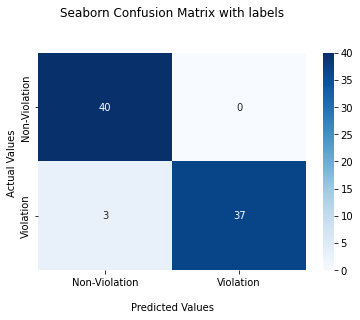

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Violation','Violation'])
ax.yaxis.set_ticklabels(['Non-Violation','Violation'])

## Display the visualization of the Confusion Matrix.
plt.show()